# Deep learning projekt 3


    Karol Widuch    - widuch@student.agh.edu.pl
    Konrad Kalita   - konradkalita@student.agh.edu.pl
        

W oparciu o załączony zbiór treningowy należy znaleźć model, który będzie przewidywał przeżywalność komórek nowotworowych naświetlanych promieniowaniem jonizującym.
Struktura załączonego pliku treningowego:
linia 1: nagłówek
linia 2: liczba N zbiorów danych (eksperymentów)
Dla każdego zbioru Zi danych z N zbiorów danych:
- opis zbioru danych: liczba Li pomiarów w zbiorze Zi, liczba atomowa, beta - stosunek prędkości jonu do prędkości światła, pozostałe parametry pomijalne
- dla każdego z Li pomiarów: dawka (w greyach), średnia przeżywalność (w %), minimalna i maksymalna przeżywalność (w %), błąd pomiaru przeżywalności (w %).

W oparciu o załączone dane należy znaleźć model regresji, który przewiduje przeżywalność w zależności od liczby atomowej, współczynnika beta i dawki. W UPEL należy załączyć notatnik z kodem do treningu/walidacji oraz plik z najlepszym modelem. Notatnik powinien umożliwić wczytanie wytrenowanego modelu, wczytanie danych o strukturze, jak plik w załączeniu, wykonanie predykcji na zbiorze testowym oraz wyliczenie jakości predykcji (mean square error, wykresy prezentujące przeżywalność przewidywaną przez model i zmierzoną w zależności od dawki, wykresy prezentujące przeżywalność przewidywaną przez model w zależności od  zmierzonej, współczynnik korelacji Pearsona między wyliczonymi i zmierzonymi przeżywalnościami).
Zbiór testowy nie jest ujawniony - zostanie użyty przez prowadzącego do ewaluacji modeli.
Warunkiem zaliczenia projektu jest uzyskanie wsp. determinacji (kwadrat wsp. korelacji) pomiędzy zmierzonymi i przewidywanym przeżywalnościami będzie co najmniej 90% (mój model osiąga 99% - wynik w załączeniu).

### Import potrzebnych bibliotek

In [1]:
import pickle
import pandas as pd
import numpy as np
import scipy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

## 1. Dane

### 1.1 Pobranie danych

In [2]:
def parse_record(record):
    data = record.split('  ')
    return (float(data[0]), float(data[1]), float(data[2]), float(data[3]), float(data[4])) if data[1] else (float(data[0]), float(data[2]), float(data[3]), float(data[4]), float(data[5]))

def parse_description(record):
    data = record.split('  ')
    return (int(float(data[0])), int(float(data[1])), float(data[4]))

In [3]:
def load_data(path):

    with open(path) as file:
        data = [line.strip() for line in file.read().splitlines()]
        
    num_of_datasets = int(data[1])
    
    data = data[2:]
    
    final_data = pd.DataFrame(columns=["atomic_number", "beta", "dose", "avg_survival", "min_survival", "max_survival", "error"])
    line = 0
    
    for dataset_num in range(num_of_datasets):
        description = parse_description(data[line])
        for record_num in range(description[0]):
            line += 1
            record = parse_record(data[line])
            final_data.loc[line-dataset_num-1] = [description[1], description[2], record[0], record[1], record[2], record[3], record[4]]
        line += 1
    
    return final_data

In [4]:
df = load_data("./SUR5_Train.DAT")

df.head()

,atomic_number,beta,dose,avg_survival,min_survival,max_survival,error
0,1.0,0.50827,0.0,100.0,100.0,100.0,1.00
1,1.0,0.50827,0.5,68.8,60.0,75.5,8.80
2,1.0,0.50827,1.0,50.0,41.4,57.8,8.60
3,1.0,0.50827,1.5,42.8,35.1,49.6,7.69
4,1.0,0.50827,2.4,23.7,22.8,25.0,0.90


### 1.2 Wstępna wizualizacja danych

Ogólna prezentacja danych, które będą odgrywały najważniejszą rolę w naszym zadaniu: 
 * atomic_number
 * beta
 * dose
 * avg_survival

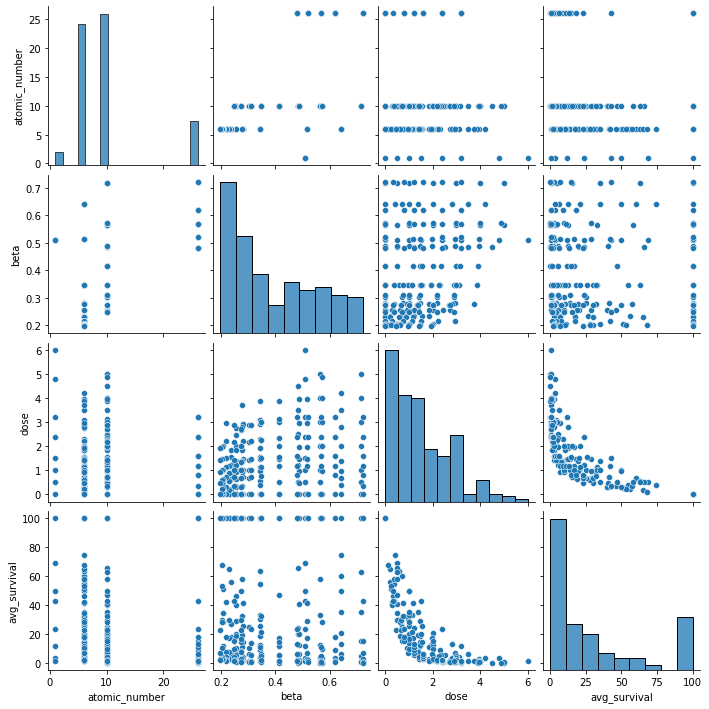

In [5]:
sns.pairplot(df[['atomic_number', 'beta', 'dose', 'avg_survival']])
plt.show()

#### Poniżej prezentuje się macierz korelacji:

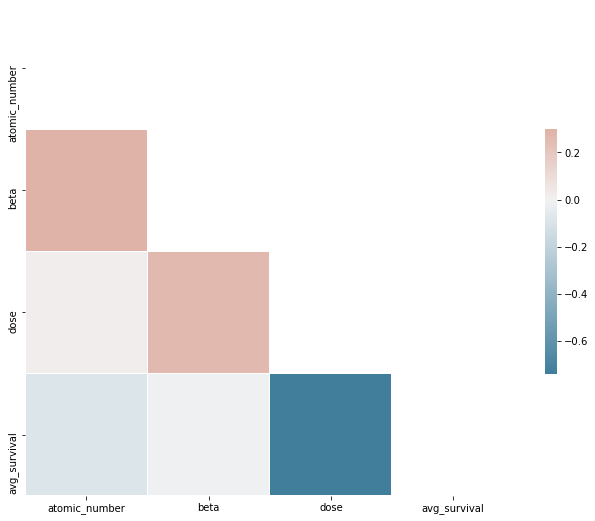

In [6]:
# copied from sns documentation

corr = df[['atomic_number', 'beta', 'dose', 'avg_survival']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#### Wniosek
* W macierzy powyżej widzimy, że średnia przeżywalność zależy najbardziej od dawki.

## 2. Model

Naszym zadaniem jest znalezienie modelu, który na naszych danych ze skutecznością niemniejszą niż 90% będzie przewidywał przeżywalność komórek nowotworowych.

### 2.1 Podział danych i tworzenie modelu

In [7]:
X, y = df[['atomic_number', 'beta', 'dose']], df['avg_survival']

# ze względu na stosunkowo niewielką ilość danych uczących decydujemy się na rozmiar zbioru testowego 10% całości

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# najlepiej radzącym sobie w większości przypadków modelem jest randomForestRegressor, więc sprawdzimy jego wyniki

model = RandomForestRegressor()

### 2.2 Wybór najlepszego modelu

In [8]:
parameters = {
    'n_estimators': (20, 50, 100, 150),
    'max_depth': (None, 2, 4, 7, 10),
    'min_samples_split': (2, 3, 5),
    'min_samples_leaf': (1, 2, 3)
}

gs_model = GridSearchCV(model, parameters)
gs_model.fit(X_train, y_train)

with open("best_model", 'wb') as file:
    pickle.dump(gs_model, file)

### 2.3 Wczytywanie modelu

In [9]:
with open("best_model", 'rb') as file:
    loaded_model = pickle.load(file)

## 3. Rezultaty

### 3.1 Analiza wyników naszego modelu

In [10]:
def test_model(model = gs_model, X_test = X_test, y_test = y_test):
    y_pred = gs_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    print(f'mean_squared_error: \t {mse:.3f}')
    R = scipy.stats.pearsonr(y_test, y_pred)[0]
    print(f'R: \t\t\t {R:.3f}')
    print(f'R^2: \t\t\t {R**2:.3f}')
    f, axs = plt.subplots(1,2, figsize=((16, 8)))
    axs[0].scatter(X_test['dose'], y_test, marker='*', c='b', label="Poprawne")
    axs[0].scatter(X_test['dose'], y_pred, marker='^', c='y', label="Przewidywane")
    axs[0].legend()
    axs[0].set_xlabel("Dawka [Gy]")
    axs[0].set_ylabel("Przeżywalność [%]")

    axs[1].scatter(y_test, y_pred, label=f'R^2 = {R**2:.3f}')
    axs[1].legend()
    axs[1].set_xlabel("Przeżywalność zmierzona [%]")
    axs[1].set_ylabel("Przeżywalność obliczona [%]")
    plt.show()

mean_squared_error: 	 12.086
R: 			 0.995
R^2: 			 0.991


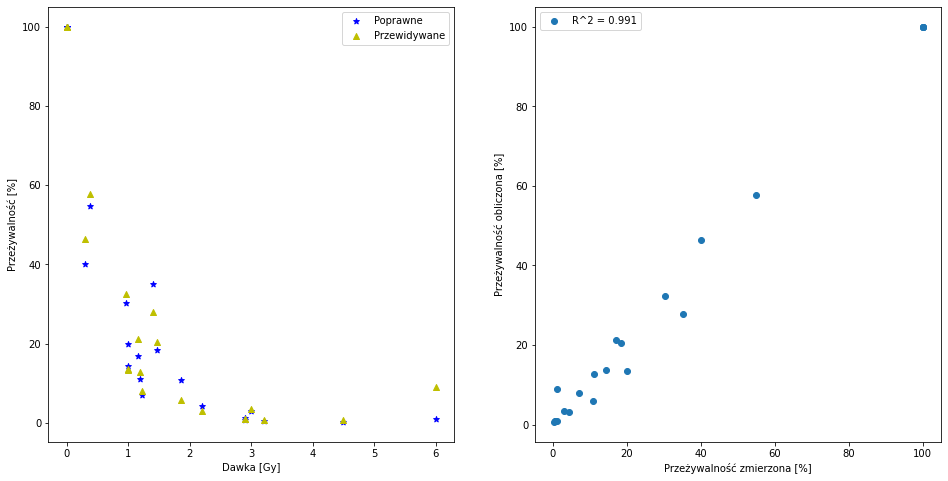

In [11]:
test_model()

### 3.2 Sprawdzanie wczytanego modelu

mean_squared_error: 	 10.345
R: 			 0.996
R^2: 			 0.991


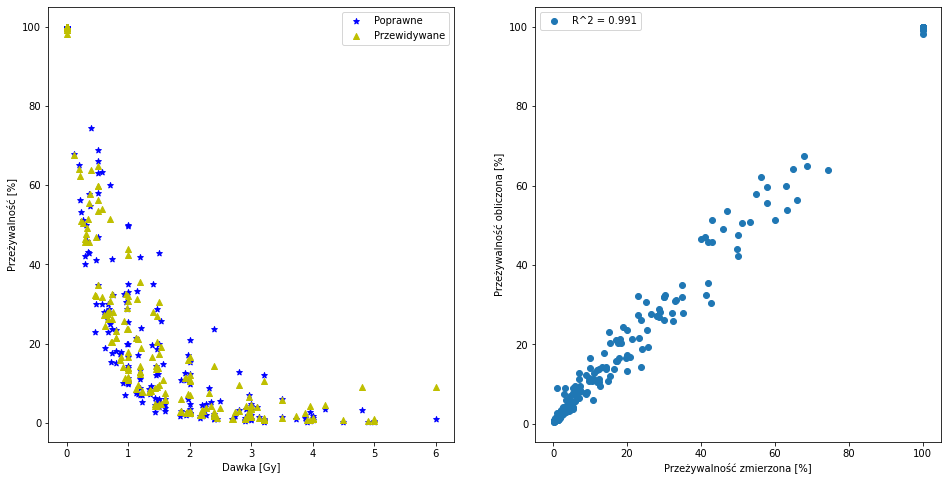

In [12]:
best_path = "best_model"
test_data_path = "./SUR5_Train.DAT"

with open(best_path, 'rb') as file:
    best_model = pickle.load(file)

df_test = load_data(test_data_path)
XTest, yTest = df_test[['atomic_number', 'beta', 'dose']], df_test['avg_survival']

test_model(best_model, XTest, yTest)